In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle


In [2]:
# Load datasets
user_df = pd.read_csv("/content/user.csv")
tourism_df = pd.read_csv("/content/tourism_with_id.csv")
rating_df = pd.read_csv("/content/tourism_rating.csv")
package_df = pd.read_csv("/content/package_tourism.csv")

In [3]:
# Display basic info about datasets
{
    "user.csv": user_df.head(),
    "tourism_with_id.csv": tourism_df.head(),
    "tourism_rating.csv": rating_df.head(),
    "package_tourism.csv": package_df.head()
}

{'user.csv':    User_Id                   Location  Age
 0        1      Semarang, Jawa Tengah   20
 1        2         Bekasi, Jawa Barat   21
 2        3        Cirebon, Jawa Barat   23
 3        4         Bekasi, Jawa Barat   21
 4        5  Lampung, Sumatera Selatan   20,
 'tourism_with_id.csv':    Place_Id                         Place_Name  \
 0         1                   Monumen Nasional   
 1         2                           Kota Tua   
 2         3                      Dunia Fantasi   
 3         4  Taman Mini Indonesia Indah (TMII)   
 4         5           Atlantis Water Adventure   
 
                                          Description       Category     City  \
 0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
 1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
 2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
 3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan

In [4]:
# Drop NaN values from rating dataset
rating_df.dropna(inplace=True)

In [5]:
# Ensure data types are correct
rating_df['User_Id'] = rating_df['User_Id'].astype(int)
rating_df['Place_Id'] = rating_df['Place_Id'].astype(int)
rating_df['Place_Ratings'] = rating_df['Place_Ratings'].astype(int)

In [6]:
# Encode User_Id and Place_Id to be continuous indices
unique_users = rating_df['User_Id'].unique()
unique_places = rating_df['Place_Id'].unique()

In [7]:
user_to_index = {user_id: i for i, user_id in enumerate(unique_users)}
place_to_index = {place_id: i for i, place_id in enumerate(unique_places)}

In [8]:
rating_df['user_idx'] = rating_df['User_Id'].map(user_to_index)
rating_df['place_idx'] = rating_df['Place_Id'].map(place_to_index)

In [9]:
# Split into training and test set (80-20 split)
train_df, test_df = train_test_split(rating_df, test_size=0.2, random_state=42)


In [10]:
# Summary of processed data
train_df.head()

,User_Id,Place_Id,Place_Ratings,user_idx,place_idx
9254,278,262,3,277,54
1561,49,251,2,48,359
1670,52,52,2,51,235
6087,183,385,1,182,139
6669,200,258,5,199,6


In [11]:
# Define Dataset
class TourismDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_idx'].values, dtype=torch.long)
        self.places = torch.tensor(df['place_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['Place_Ratings'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.places[idx], self.ratings[idx]


In [12]:
# Define Transformer-based Model
class TransformerRecommender(nn.Module):
    def __init__(self, num_users, num_places, embed_dim=64, num_heads=4, num_layers=2):
        super(TransformerRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.place_embedding = nn.Embedding(num_places, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, user_ids, place_ids):
        user_emb = self.user_embedding(user_ids)
        place_emb = self.place_embedding(place_ids)
        interaction = user_emb + place_emb
        transformed = self.transformer(interaction.unsqueeze(0)).squeeze(0)
        return self.fc(transformed).squeeze()

In [13]:
# Prepare Dataloader
train_dataset = TourismDataset(train_df)
test_dataset = TourismDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Initialize Model
num_users = len(user_to_index)
num_places = len(place_to_index)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerRecommender(num_users, num_places).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
# Training Loop
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for users, places, ratings in train_loader:
            users, places, ratings = users.to(device), places.to(device), ratings.to(device)
            optimizer.zero_grad()
            predictions = model(users, places)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return loss_history

In [16]:
# Train the model
loss_history = train_model(model, train_loader, optimizer, criterion, epochs=30)

Epoch 1/30, Loss: 1.9914
Epoch 2/30, Loss: 1.9156
Epoch 3/30, Loss: 1.8968
Epoch 4/30, Loss: 1.8763
Epoch 5/30, Loss: 1.8535
Epoch 6/30, Loss: 1.8238
Epoch 7/30, Loss: 1.8067
Epoch 8/30, Loss: 1.7742
Epoch 9/30, Loss: 1.7540
Epoch 10/30, Loss: 1.7236
Epoch 11/30, Loss: 1.6863
Epoch 12/30, Loss: 1.6713
Epoch 13/30, Loss: 1.6307
Epoch 14/30, Loss: 1.5793
Epoch 15/30, Loss: 1.5614
Epoch 16/30, Loss: 1.5053
Epoch 17/30, Loss: 1.4612
Epoch 18/30, Loss: 1.4103
Epoch 19/30, Loss: 1.3608
Epoch 20/30, Loss: 1.3375
Epoch 21/30, Loss: 1.2734
Epoch 22/30, Loss: 1.2274
Epoch 23/30, Loss: 1.1955
Epoch 24/30, Loss: 1.1540
Epoch 25/30, Loss: 1.1049
Epoch 26/30, Loss: 1.0631
Epoch 27/30, Loss: 1.0086
Epoch 28/30, Loss: 0.9905
Epoch 29/30, Loss: 0.9466
Epoch 30/30, Loss: 0.8952


In [21]:
# Save Model as .pkl
with open("transformer_recommender.pkl", "wb") as f:
    pickle.dump(model, f)


In [22]:
# Evaluation Metrics
def hit_rate(predictions, ground_truth, top_k=10):
    hits = sum([1 if gt in pred[:top_k] else 0 for gt, pred in zip(ground_truth, predictions)])
    return hits / len(ground_truth)

def ndcg(predictions, ground_truth, top_k=10):
    def dcg(rels):
        return sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(rels)])

    total_ndcg = 0
    for gt, pred in zip(ground_truth, predictions):
        ideal = [1 if p == gt else 0 for p in pred[:top_k]]
        total_ndcg += dcg(ideal) / dcg(sorted(ideal, reverse=True))
    return total_ndcg / len(ground_truth)

In [23]:
# Inference Function
def recommend_places(user_id, model, top_k=10):
    user_idx = user_to_index.get(user_id, None)
    if user_idx is None:
        return []

    place_indices = torch.tensor(list(place_to_index.values()), dtype=torch.long).to(device)
    user_indices = torch.tensor([user_idx] * len(place_indices), dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        scores = model(user_indices, place_indices)

    top_places = torch.argsort(scores, descending=True)[:top_k]
    recommended_place_ids = [list(place_to_index.keys())[i] for i in top_places.cpu().numpy()]
    return recommended_place_ids


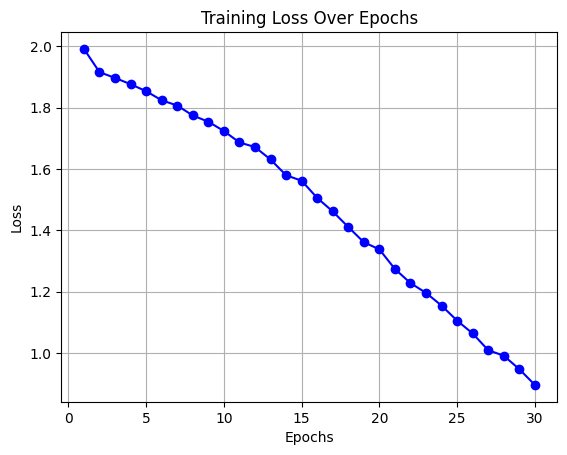

In [24]:
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()
